<a href="https://colab.research.google.com/github/Ashrafalaghbari/Mutivariate-long-term-forecasting-of-oil-production/blob/main/multivariate_model_multistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]


In [4]:
#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #adjusted MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2* result/ len(actual) 
    return result * 100

In [5]:
colum = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv')
colum.columns

Index(['DATEPRD', 'BORE_OIL_VOL', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P',
       'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'F_4_ON_STREAM_HRS', 'F_4_BORE_WI_VOL', 'F_5_ON_STREAM_HRS',
       'F_5_BORE_WI_VOL'],
      dtype='object')

In [6]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv',
                     usecols=["DATEPRD",'AVG_CHOKE_SIZE_P','AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE',
                              'ON_STREAM_HRS','AVG_WHP_P','AVG_WHT_P','F_4_BORE_WI_VOL','F_5_BORE_WI_VOL',
                              'DP_CHOKE_SIZE', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
                              "BORE_OIL_VOL"],
                  parse_dates=["DATEPRD"], index_col="DATEPRD")
# =series[["ON_STREAM_HRS",'AVG_CHOKE_SIZE_P', "BORE_OIL_VOL"]] # change the order of BORE_OIL_VOL
#series =series[["ON_STREAM_HRS", "BORE_OIL_VOL"]] # chan

In [7]:
column_to_move = series.pop("BORE_OIL_VOL")

# insert column with insert(location, column_name, column_value)

series.insert(len(series.columns), "BORE_OIL_VOL", column_to_move)

In [8]:
series = series.iloc[:80]
series.shape

(80, 12)

In [9]:
series.corr().iloc[:,-1] #200

ON_STREAM_HRS               0.901937
AVG_DOWNHOLE_PRESSURE      -0.660922
AVG_DOWNHOLE_TEMPERATURE    0.328251
AVG_CHOKE_SIZE_P            0.886013
AVG_WHP_P                  -0.840031
AVG_WHT_P                   0.684491
DP_CHOKE_SIZE              -0.844902
BORE_GAS_VOL                0.997736
BORE_WAT_VOL                0.716904
F_4_BORE_WI_VOL             0.653387
F_5_BORE_WI_VOL             0.582954
BORE_OIL_VOL                1.000000
Name: BORE_OIL_VOL, dtype: float64

In [10]:
series.corr().iloc[:,-1] #80 

ON_STREAM_HRS               0.901937
AVG_DOWNHOLE_PRESSURE      -0.660922
AVG_DOWNHOLE_TEMPERATURE    0.328251
AVG_CHOKE_SIZE_P            0.886013
AVG_WHP_P                  -0.840031
AVG_WHT_P                   0.684491
DP_CHOKE_SIZE              -0.844902
BORE_GAS_VOL                0.997736
BORE_WAT_VOL                0.716904
F_4_BORE_WI_VOL             0.653387
F_5_BORE_WI_VOL             0.582954
BORE_OIL_VOL                1.000000
Name: BORE_OIL_VOL, dtype: float64

In [12]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2010-01-01 to 2010-03-24
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ON_STREAM_HRS             80 non-null     float64
 1   AVG_DOWNHOLE_PRESSURE     80 non-null     float64
 2   AVG_DOWNHOLE_TEMPERATURE  80 non-null     float64
 3   AVG_CHOKE_SIZE_P          80 non-null     float64
 4   AVG_WHP_P                 80 non-null     float64
 5   AVG_WHT_P                 80 non-null     float64
 6   DP_CHOKE_SIZE             80 non-null     float64
 7   BORE_GAS_VOL              80 non-null     float64
 8   BORE_WAT_VOL              80 non-null     float64
 9   F_4_BORE_WI_VOL           80 non-null     float64
 10  F_5_BORE_WI_VOL           80 non-null     float64
 11  BORE_OIL_VOL              80 non-null     float64
dtypes: float64(12)
memory usage: 8.1 KB


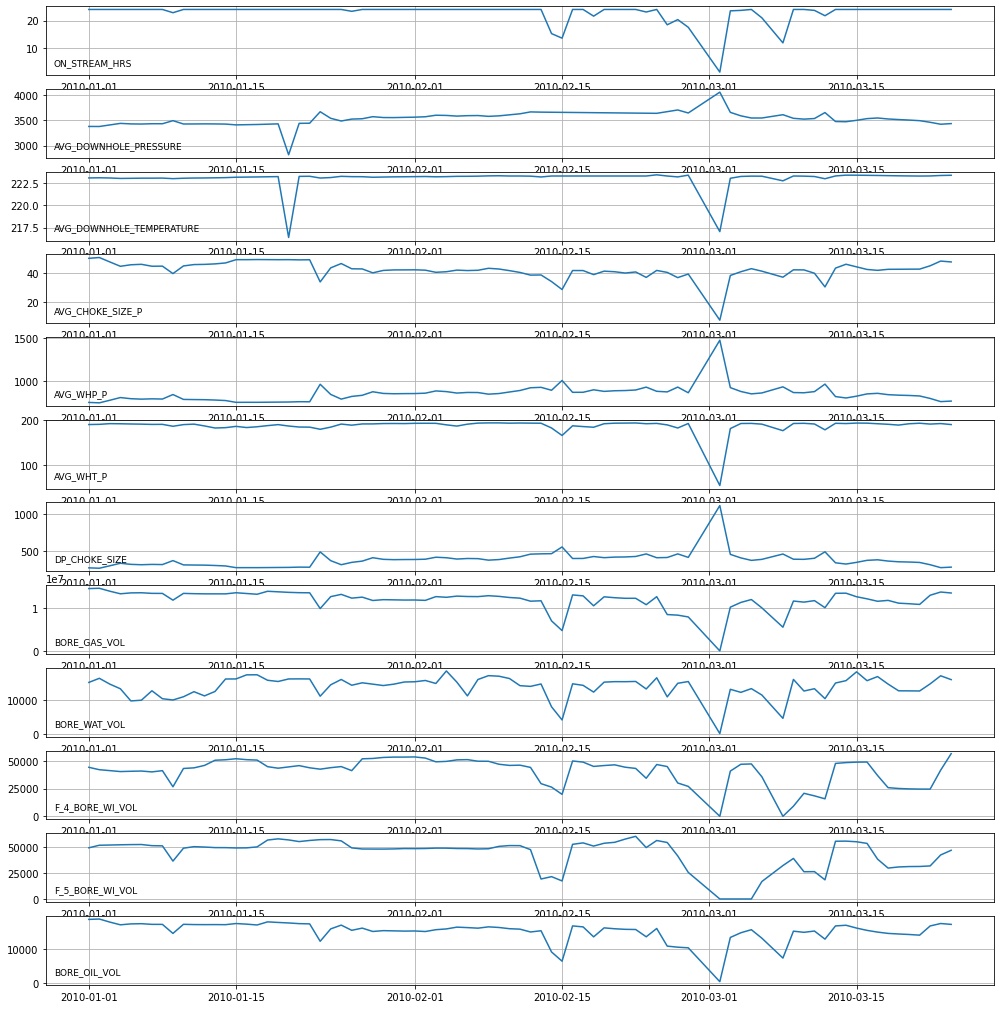

In [11]:
# Data visulaization and disribution plots for well F-14 after including the injectors
data = series.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 18))

axs = axs.ravel()

for id, column in enumerate(data):

    axs[id].plot(series[column])
    axs[id].grid(True)
    axs[id].legend([column], loc='lower left', fontsize=9, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

**Multi-output forecasting strategy**

In [651]:
# # # convert series to stationary 
# series_diff = series.copy()
# diff_order = 1
# series_diff['BORE_OIL_VOL'] = series_diff['BORE_OIL_VOL'].diff(diff_order)
# # convert the stationary series to supervise learning
timesteps = 5 # lag features
steps_ahead = 1
series_supervised = series_to_supervised(series, series.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

In [630]:
series_supervised.head()

,ON_STREAM_HRS(t-5),AVG_DOWNHOLE_PRESSURE(t-5),AVG_DOWNHOLE_TEMPERATURE(t-5),AVG_CHOKE_SIZE_P(t-5),AVG_WHP_P(t-5),AVG_WHT_P(t-5),DP_CHOKE_SIZE(t-5),BORE_GAS_VOL(t-5),BORE_WAT_VOL(t-5),F_4_BORE_WI_VOL(t-5),...,AVG_WHP_P(t),AVG_WHT_P(t),DP_CHOKE_SIZE(t),BORE_GAS_VOL(t),BORE_WAT_VOL(t),merged_onStreams,merged_choke,F_4_BORE_WI_VOL(t),F_5_BORE_WI_VOL(t),BORE_OIL_VOL(t)
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2010-01-06,24.0,3378.643673,223.079164,50.150825,749.568621,190.264943,271.390953,1.462166e+07,15304.241356,44109.287732,...,787.778892,191.155238,313.483219,1.364834e+07,10054.073550,48.00000,91.797742,40733.215195,52212.108216,17331.761803
2010-01-07,24.0,3377.769461,223.095696,50.694654,744.664780,190.708397,266.368677,1.469266e+07,16519.118273,41936.969541,...,791.388814,190.547894,317.780795,1.350971e+07,12837.943721,48.00000,90.794083,39969.857579,51109.971510,17138.601719
2010-01-08,24.0,3408.561097,223.074953,47.665676,774.827418,192.268341,299.398157,1.400904e+07,14796.150455,41114.572918,...,788.842189,190.683690,315.702450,1.349732e+07,10488.510768,48.00000,89.545331,41079.035678,50933.111950,17127.657449
2010-01-09,24.0,3439.266918,223.022721,44.706230,806.160543,191.994925,333.246980,1.341015e+07,13428.619835,40267.292699,...,841.210210,186.402569,369.184766,1.192758e+07,10120.619746,46.83333,84.534024,26561.870164,36311.076594,14477.823141
2010-01-10,24.0,3429.064568,223.035833,45.743761,792.735696,191.503603,318.470614,1.361768e+07,9839.905499,40524.238503,...,784.502885,190.103419,311.207552,1.350295e+07,11071.387516,46.83333,84.672505,43049.644968,48695.944867,17149.483091


In [480]:
int(0.8*100)

80

In [539]:
inv_scale_y

array([17128.97830887])

In [614]:
inv_scale_yhat

array([16090.044, 17022.682], dtype=float32)

In [613]:
series[len(train):]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_GAS_VOL,BORE_WAT_VOL,F_4_BORE_WI_VOL,F_5_BORE_WI_VOL,BORE_OIL_VOL
DATEPRD,,,,,,,,,,,,
2010-03-18,24.0,3526.281013,223.337147,42.642245,839.723236,190.830086,362.805876,1.187655e+07,14815.963359,25775.205860,29618.199562,14483.106582
2010-03-19,24.0,3514.913608,223.317147,42.677826,833.817448,189.049475,353.089956,1.123098e+07,12827.754228,25032.583179,30697.245146,14311.772141
2010-03-20,24.0,3504.763562,223.303034,42.735827,830.434355,192.043733,349.821119,1.109804e+07,12808.884796,24664.586214,31087.782101,14163.898694
2010-03-21,24.0,3492.841901,223.291353,42.770594,824.547904,193.201259,344.134244,1.093559e+07,12776.869660,24483.497384,31164.747774,13967.153418
2010-03-22,24.0,3460.862128,223.300709,45.041136,795.900307,191.314792,313.550160,1.307194e+07,14874.773088,24458.580144,31681.968615,16668.186784
2010-03-23,24.0,3422.510183,223.354927,48.268275,759.105257,192.454799,274.186897,1.382048e+07,17263.328663,41520.546816,42199.917717,17384.218823
2010-03-24,24.0,3435.084903,223.378091,47.668794,765.122928,190.217152,280.992874,1.359333e+07,16125.376130,56392.726193,46679.037762,17128.978309


In [656]:
series_supervised.iloc[len(train):, -12:]

,AVG_DOWNHOLE_TEMPERATURE(t-1),AVG_WHP_P(t-1),AVG_WHT_P(t-1),DP_CHOKE_SIZE(t-1),BORE_GAS_VOL(t-1),BORE_WAT_VOL(t-1),F_4_BORE_WI_VOL(t-1),F_5_BORE_WI_VOL(t-1),BORE_OIL_VOL(t-1),merged_onStreams,merged_choke,BORE_OIL_VOL(t)
DATEPRD,,,,,,,,,,,,
2010-03-23,223.300709,795.900307,191.314792,313.550160,1.307194e+07,14874.773088,24458.580144,31681.968615,16668.186784,48.0,93.309411,17384.218823
2010-03-24,223.354927,759.105257,192.454799,274.186897,1.382048e+07,17263.328663,41520.546816,42199.917717,17384.218823,48.0,95.937069,17128.978309


In [548]:
int(series_supervised.shape[0]*0.98)

73

In [57]:
# # time-dependent variables 
# shifted_ON_STREAM_HRS = series_diff["ON_STREAM_HRS"].shift(-(timesteps + diff_order)).dropna()
# shifted_ON_STREAM_HRS.index = series_supervised.index.values 
# shifted_AVG_CHOKE_SIZE_P = series_diff['AVG_CHOKE_SIZE_P'].shift(-(timesteps + diff_order)).dropna()
# shifted_AVG_CHOKE_SIZE_P.index = series_supervised.index.values
# series_supervised = pd.concat([shifted_ON_STREAM_HRS,shifted_AVG_CHOKE_SIZE_P, series_supervised], axis=1) 

In [ ]:
# #drop all the variables that we don't want to predict
# vars_y = series_supervised.columns[-steps_ahead*len(series.columns):]
# vars_name_to_drop = ['ON_STREAM_HRS(t+)']
# vars_to_drop = vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
# series_supervised.drop(columns=vars_to_drop, inplace=True)

In [ ]:
# # bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
# ON_STREAM_HRS_t = series_supervised.pop('ON_STREAM_HRS(t)')
# series_supervised.insert(len(series_supervised.columns)-1, 'ON_STREAM_HRS(t)', ON_STREAM_HRS_t)

In [652]:
merged_onStreams = series_supervised["ON_STREAM_HRS(t-1)"] + (series_supervised["ON_STREAM_HRS(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_onStreams', merged_onStreams)

In [653]:
merged_choke = series_supervised["AVG_CHOKE_SIZE_P(t-1)"] + (series_supervised["AVG_CHOKE_SIZE_P(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_choke', merged_choke)

In [654]:
series_supervised.drop(['ON_STREAM_HRS(t-1)', 'AVG_CHOKE_SIZE_P(t-1)'], axis=1, inplace= True)

In [655]:
series_supervised.drop(['AVG_CHOKE_SIZE_P(t)','ON_STREAM_HRS(t)',
                        'AVG_DOWNHOLE_PRESSURE(t)','AVG_DOWNHOLE_TEMPERATURE(t)',
                        'AVG_WHP_P(t)','AVG_WHT_P(t)','F_4_BORE_WI_VOL(t)',
                        'F_5_BORE_WI_VOL(t)', 'DP_CHOKE_SIZE(t)', 'BORE_GAS_VOL(t)', 'BORE_WAT_VOL(t)'], axis=1, inplace= True)


In [633]:
# # split into train and test sets
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.98)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print(train.shape, test.shape)

(73, 61) (2, 61)


In [634]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(train_scaled.shape, test_scaled.shape)

(73, 61) (2, 61)


In [635]:
# # reshape input to be 3D [samples, timesteps, features]
n_features = 12 

train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], timesteps, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(73, 5, 12) (73, 1) (2, 5, 12) (2, 1)


In [645]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

# fit the model
neurons= [12]#12 
n_epochs=208#186
batch_size=1

model = Sequential()
#model.add(LSTM(neurons[0], batch_input_shape=(batch_size, timesteps, n_features), stateful=True))
#model.add(LSTM(neurons[0], input_shape=(timesteps, n_features), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(neurons[0], input_shape=(timesteps, n_features)))
model.add(Dense(steps_ahead))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

from keras.callbacks import EarlyStopping
# early stopping
#es = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=1, validation_data=(test_X, test_y), verbose=2,
                     shuffle=False)
#model.reset_states()

Epoch 1/208
73/73 - 3s - loss: 0.2915 - val_loss: 0.2558 - 3s/epoch - 36ms/step
Epoch 2/208
73/73 - 0s - loss: 0.1456 - val_loss: 0.1177 - 170ms/epoch - 2ms/step
Epoch 3/208
73/73 - 0s - loss: 0.0785 - val_loss: 0.0542 - 174ms/epoch - 2ms/step
Epoch 4/208
73/73 - 0s - loss: 0.0552 - val_loss: 0.0304 - 162ms/epoch - 2ms/step
Epoch 5/208
73/73 - 0s - loss: 0.0482 - val_loss: 0.0223 - 190ms/epoch - 3ms/step
Epoch 6/208
73/73 - 0s - loss: 0.0458 - val_loss: 0.0196 - 185ms/epoch - 3ms/step
Epoch 7/208
73/73 - 0s - loss: 0.0445 - val_loss: 0.0188 - 237ms/epoch - 3ms/step
Epoch 8/208
73/73 - 0s - loss: 0.0436 - val_loss: 0.0185 - 232ms/epoch - 3ms/step
Epoch 9/208
73/73 - 0s - loss: 0.0428 - val_loss: 0.0184 - 235ms/epoch - 3ms/step
Epoch 10/208
73/73 - 0s - loss: 0.0420 - val_loss: 0.0183 - 242ms/epoch - 3ms/step
Epoch 11/208
73/73 - 0s - loss: 0.0413 - val_loss: 0.0183 - 231ms/epoch - 3ms/step
Epoch 12/208
73/73 - 0s - loss: 0.0405 - val_loss: 0.0183 - 247ms/epoch - 3ms/step
Epoch 13/208
73

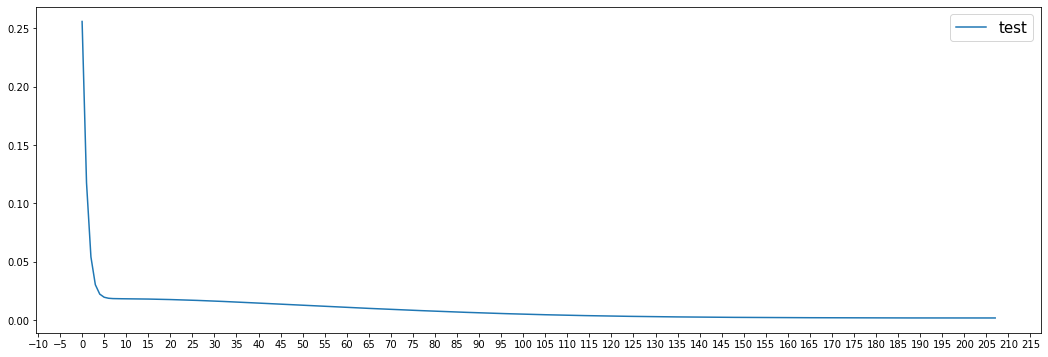

In [646]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
#plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(fontsize=15)
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [647]:
# make a prediction 
# select the number of obersvtions for prediction
n_obs = len(test)
yhat = model.predict(test_X[-n_obs:])


# invert scaling 
scaled_y = pd.DataFrame(test_y)
scaled_yhat = pd.DataFrame(yhat.ravel()) ## ravel () converting into 1D array
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
inv_scale_y = scaled_y.apply(transform_column, axis=0)
inv_scale_y = inv_scale_y.values.ravel() 
# invert scaling for forecast
inv_scale_yhat = scaled_yhat.apply(transform_column, axis=0)
inv_scale_yhat = inv_scale_yhat.values.ravel()

1/1 [==============================] - 0s 394ms/step


In [556]:
test_X[-n_obs:].shape

(1, 5, 12)

In [648]:
pd.DataFrame(inv_scale_y)

,0
0,17384.218823
1,17128.978309


In [649]:
pd.DataFrame(inv_scale_yhat)

,0
0,16312.861328
1,17241.490234


In [607]:
pd.DataFrame(inv_scale_yhat)

,0
0,16090.043945
1,17022.681641


In [566]:
pd.DataFrame(inv_scale_yhat)

,0
0,16130.116211
1,17011.335938


In [260]:
# Invert the Differencing for actual 
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,-1])
n_vars = df.shape[1]
columns = df.columns
cols, names = list(), list()
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
    else:
        names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.iloc[:-1,0]
#drop all the variables that we don't want to predict
#agg.drop(columns=vars_to_drop, inplace=True)
agg = agg.to_numpy()
inv_y = np.add(inv_scale_y,agg)

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [ ]:
# Invert the Differencing for forecast
# to invert the diffrenced predicted values,the the predicted differenced value is added
# to previous predicted diffenced values and last available observation in test set(Xt) as explained above
originalSeries_supervised = series_to_supervised(series, series.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

current_timestep = 1
# actual value of oil rate at current time step
# steps_ahead = 4
#drop all the variables that we don't want to predict
vars_y = originalSeries_supervised.columns[-steps_ahead*len(series.columns):]
vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
originalSeries_supervised.drop(columns=vars_to_drop, inplace=True)
originalSeries_xt = originalSeries_supervised.iloc[-len(test):,-steps_ahead-2]


# A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
col = []
#inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)
inv_yhat_cum = inv_scale_yhat

for i in range(n_obs):
    #.ravel() flattens the series into a one-dimensional array
    inverted_diff_yhat = originalSeries_xt[-n_obs:].ravel()[i] + inv_yhat_cum[i]
    col.append(inverted_diff_yhat)
#col = pd.DataFrame.from_records(col) # creates a DataFrame from a list of records
col = pd.DataFrame(col)
#col.columns = pd.RangeIndex(start=1, stop=steps_ahead+1, step=1)
inv_yhat = col.values.ravel() # convert df to NumpyArray

In [262]:
inv_yhat = np.add(inv_scale_yhat,agg)

In [496]:
inv_scale_y[:10]

array([16403.70024859, 15966.81000431, 14921.06609396, 14972.83123519,
       16072.66751671, 15913.59820664,     0.        ,  5064.42969891,
       14651.48481164, 16667.24331273])

In [497]:
inv_scale_yhat[:10]

array([17791.307, 17736.64 , 16941.434, 15964.409, 15485.129, 15332.466,
       15214.239, 11251.009,  9731.124, 10704.162], dtype=float32)

In [375]:
series[-20:]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_GAS_VOL,BORE_WAT_VOL,F_4_BORE_WI_VOL,F_5_BORE_WI_VOL,BORE_OIL_VOL
DATEPRD,,,,,,,,,,,,
2010-03-15,24.00000,3499.867441,223.386533,44.316175,822.171389,193.543561,345.369775,1.272429e+07,18427.132319,48733.431795,54860.563137,16048.011459
2010-03-16,24.00000,3533.330714,223.372252,42.540061,848.689653,193.351508,372.702517,1.223783e+07,15816.546429,48849.500855,53280.373128,15370.347265
2010-03-17,24.00000,3545.796953,223.356792,41.938664,855.211230,192.062794,379.983590,1.167131e+07,17030.542773,36742.872825,38197.975770,14866.281844
2010-03-18,24.00000,3526.281013,223.337147,42.642245,839.723236,190.830086,362.805876,1.187655e+07,14815.963359,25775.205860,29618.199562,14483.106582
2010-03-19,24.00000,3514.913608,223.317147,42.677826,833.817448,189.049475,353.089956,1.123098e+07,12827.754228,25032.583179,30697.245146,14311.772141
2010-03-20,24.00000,3504.763562,223.303034,42.735827,830.434355,192.043733,349.821119,1.109804e+07,12808.884796,24664.586214,31087.782101,14163.898694
2010-03-21,24.00000,3492.841901,223.291353,42.770594,824.547904,193.201259,344.134244,1.093559e+07,12776.869660,24483.497384,31164.747774,13967.153418
2010-03-22,24.00000,3460.862128,223.300709,45.041136,795.900307,191.314792,313.550160,1.307194e+07,14874.773088,24458.580144,31681.968615,16668.186784
2010-03-23,24.00000,3422.510183,223.354927,48.268275,759.105257,192.454799,274.186897,1.382048e+07,17263.328663,41520.546816,42199.917717,17384.218823


In [264]:
inv_yhat[:10] 

array([3288.89158196, 3346.74592036, 3103.52754455, 1377.72767492,
       3303.75001182, -133.23603625,  723.8719873 , 4809.38627532,
       1305.95354536, 3142.61230775])

In [246]:
inv_yhat[:10] # 1 time steps # on stream choke

array([3394.35349602, 3444.29474848, 3407.12422423, 2069.87415929,
       2673.50782432,  726.9788075 ,  191.03995605, 2852.41166594,
       1233.41545942, 2469.22461244])

In [225]:
inv_yhat[:10] # 4 time steps # on stream choke

array([3362.01447504, 3014.15742736, 1575.44740148, 2900.26856651,
        196.33037   ,  969.9657373 , 4537.10893157, 1709.12542036,
       2967.28906556, 1227.26407666])

In [204]:
inv_yhat[:10]# 4 time steps # on stream

array([3357.58478754, 3198.6486383 , 1894.60365148, 2831.45606651,
        624.30595593,  780.4735498 , 3790.01518157, 1856.40471723,
       3131.147464  , 1301.48477978])

In [161]:
inv_yhat[:10]

array([3397.68342036, 2977.08809142, 1739.45619054, 2572.84473839,
         15.59990125,  623.75284667, 4017.29447844, 1411.54241254,
       2912.24316712, 1379.89298291])

In [ ]:
inv_yhat[10:20]

array([ 907.45060009, 3011.43941447, 3340.06765995, 3333.45754088,
       3341.38863642, 3353.24552656, 3399.83067438, 3391.99224271,
       2528.66725041, 2690.08993581])

In [ ]:
inv_yhat[10:20]

array([ 907.45060009, 3011.43941447, 3340.06765995, 3333.45754088,
       3341.38863642, 3353.24552656, 3399.83067438, 3391.99224271,
       2528.66725041, 2690.08993581])

In [ ]:
inv_yhat[10:20]

array([ 907.45060009, 3011.43941447, 3340.06765995, 3333.45754088,
       3341.38863642, 3353.24552656, 3399.83067438, 3391.99224271,
       2528.66725041, 2690.08993581])

In [ ]:
MAPE(inv_y[10:15],inv_yhat[10:15])

16.15701296093893

In [ ]:
inv_y.shape, inv_yhat.shape

((369,), (369,))

In [162]:
# Performance evaluation

rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
RMSPE_test = RMSPE(inv_y, inv_yhat)
print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.5f' % MAE_test)
MAPE_test = MAPE(inv_y, inv_yhat)
print('Test MAPE: %.5f' % MAPE_test)
r2 = r2_score(inv_y, inv_yhat)
print('Test r2: %.5f' % r2)
wMAPE_test = wMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % wMAPE_test)
SMAPE_test = SMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % SMAPE_test)

Test RMSE: 449.03130
Test RMSPE: 19544194831094544.00000
Test MAE: 213.63827
Test MAPE: 1353133045674894.00000
Test r2: 0.60894
Test wMAPE: 9.53361 
Test wMAPE: 14.70437 


In [ ]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# calculate the score for each day

for i in range(test_y.shape[1]):
    result_rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
    result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
    result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
    result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
    result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)
    
## calculate overall score
print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

IndexError: ignored

In [ ]:
Test RMSE: 555.56135
Test MAE: 277.11301
Test r2: 0.39641
Test wMAPE: 12.32902 
Test SMAPE: 17.45901

In [ ]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

In [ ]:
inv_yhat

In [ ]:
inv_yhat[-1]

In [ ]:
plt.plot(inv_yhat[-1], label = "predicted")
plt.plot(inv_y[-1], label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
#comparing predictions and actual values
act_pred = pd.DataFrame({"actual":inv_y.flatten(), "prediction":inv_yhat.flatten()})
act_pred.head(5)

In [ ]:
series_to_supervised(series, series.columns, n_in=2, n_out=steps_ahead, dropnan=True).iloc[-len(test):-len(test)+5]

In [ ]:
r2_score(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

In [ ]:
wMAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

In [ ]:
MAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])